# **Problem Statement:**
The contact center analytics team has been requested to develop insights as to what is driving tickets being logged into their contact centre as they cannot trust the ‘Ticket Type’ and ‘Ticket Subject’ fields that agents select in the CRM. They have retrieved a set of tickets and need to develop insights, to help give the contact center guidance on what most of their ticket drivers are about.






## **Instructions:**

In this case study, you will be working with the Customer Support Ticket Dataset from Kaggle (https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset). Use the trusted data available in the tickets, including the Ticket Description that the customer has provided. Do not use the untrusted fields.


1.	Using Python and your preferred IDE, import the data through any appropriate method (API preferred, or directly imported)

2.	Analyze the data and pre-process the data if and where required, develop any appropriate additional features that you feel necessary for the modeling.

3.	Prepare the data appropriately for modeling to take place.

4.	Using appropriate Python packages/libraries, build an unsupervised topic model that allocates a topic to each ticket.

5.	Use a supervised classification model to follow a similar approach, by pre-defining and pre-labelling the tickets with a topic and training and testing a classification model. Use no more than 50 different pre-defined topics.

6.	Chose the model that you deem most suitable (the supervised classification model or the unsupervised topic model) and visualise the data and model output into a BI visualization tool, such as Power BI, Tableau or other (free/trial). Apply useful titles and filters so users can interact with the data.

7.	Ensure to comment your code, to ensure the evaluator can understand your thinking.

8.	Submit your Notebook file as well as the dashboard file, as your deliverables.


**Importing Usefull Python Library**

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score
from gensim import corpora
from gensim.models import LdaModel
from sklearn.metrics import confusion_matrix
from pprint import pprint


import warnings
warnings.filterwarnings('ignore')

In [320]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading & Understaning the dataset**

In [321]:
customer_ticket_df = pd.read_csv('/content/drive/MyDrive/UpGrad/Customer Support Ticket Classification/customer_support_tickets.csv')

In [322]:
customer_ticket_df.shape

(8469, 17)

In [323]:
customer_ticket_df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [324]:
customer_ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

**Handle Missing Data**

In [325]:
missing_values = round(customer_ticket_df.isnull().mean()*100,2)
missing_values[missing_values>0]

Resolution                      67.30
First Response Time             33.29
Time to Resolution              67.30
Customer Satisfaction Rating    67.30
dtype: float64

**Drop the features with high number of missing value**

**I will Keep Resolution feature as we can concat it with ticket description and find better insights into the topic of issue**

In [326]:
customer_ticket_df.drop(['First Response Time','Time to Resolution','Customer Satisfaction Rating'], axis=1, inplace = True)

In [327]:
customer_ticket_df.drop(['Ticket Subject','Ticket Type'], axis=1, inplace = True)

In [328]:
customer_ticket_df.shape

(8469, 12)

In [329]:
customer_ticket_df.describe()

,Ticket ID,Customer Age
count,8469.000000,8469.000000
mean,4235.000000,44.026804
std,2444.934048,15.296112
min,1.000000,18.000000
25%,2118.000000,31.000000
50%,4235.000000,44.000000
75%,6352.000000,57.000000
max,8469.000000,70.000000


**Feature Engineering**

In [330]:
customer_ticket_df['Text_content'] = customer_ticket_df['Resolution'].fillna('') + ' ' + customer_ticket_df['Ticket Description'].fillna('')

In [331]:
# Dropping duplicate column

customer_ticket_df.drop(['Resolution','Ticket Description'], axis = 1, inplace = True)

In [332]:
customer_ticket_df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Status,Ticket Priority,Ticket Channel,Text_content
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Pending Customer Response,Critical,Social media,I'm having an issue with the {product_purchas...
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Pending Customer Response,Critical,Chat,I'm having an issue with the {product_purchas...
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Closed,Low,Social media,Case maybe show recently my computer follow. I...
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Closed,Low,Social media,Try capital clearly never color toward story. ...
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Closed,Low,Email,West decision evidence bit. I'm having an issu...


## **Data Visualization**

<Axes: xlabel='Product Purchased'>

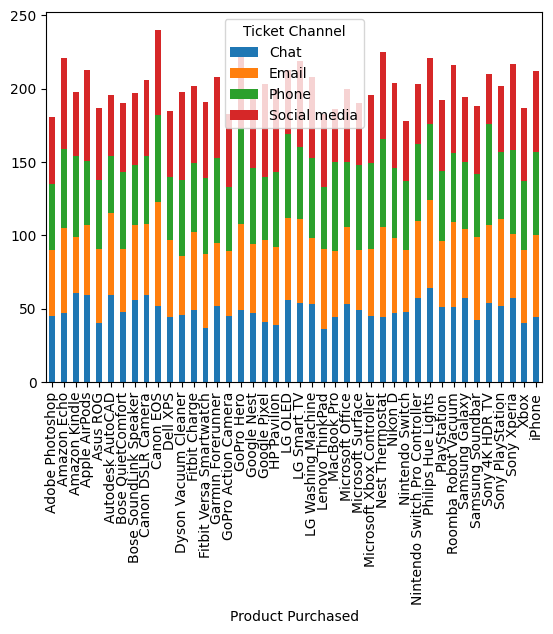

In [333]:
# Product Purchased vs Ticket Channel

customer_ticket_df.groupby(['Product Purchased', 'Ticket Channel'])['Ticket ID'].count().unstack().plot(kind='bar', stacked=True)

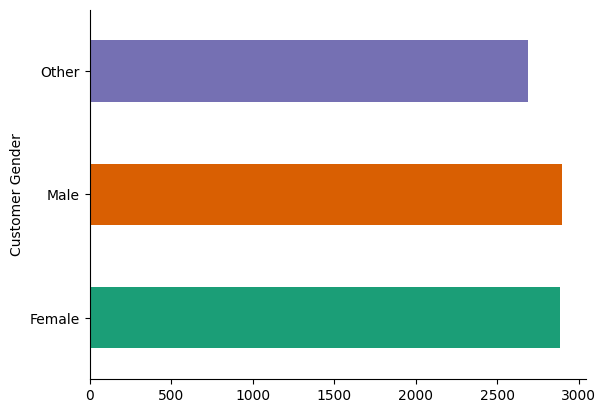

In [334]:
# Customer Gender Distribution

customer_ticket_df.groupby('Customer Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

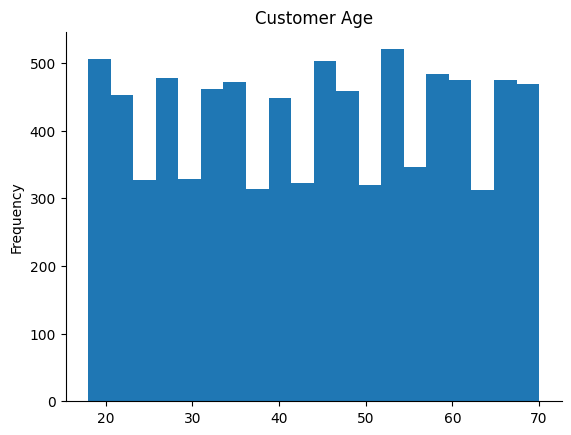

In [335]:
# Customer Age Distribution

customer_ticket_df['Customer Age'].plot(kind='hist', bins=20, title='Customer Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

## **Introducing Topic Label**

**Adding topic to dataset based on text content using LDA**

In [336]:
# using tfidf to convert word to vector
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(customer_ticket_df['Text_content'])

# Fit LDA model
lda_model = LatentDirichletAllocation(n_components=50, random_state=42)
lda_output = lda_model.fit_transform(tfidf)

In [337]:
# Get the topic for each row
topics = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
topic_words = [[tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in topics]

# Add the topic to the dataframe
customer_ticket_df['Topic'] = lda_output.argmax(axis=1)

# Print the topics
for i, topic in enumerate(topic_words):
  print(f"Topic {i+1}: {', '.join(topic)}")

Topic 1: shipping, choose, instructions, follow, refer, idea, program, wall, congress, black
Topic 2: longer, life, used, battery, decrease, sudden, website, official, reviewed, cache
Topic 3: wrong, request, month, transaction, sent, asked, sit, form, goes, company
Topic 4: return, click, select, button, condition, rate, cancel, weeks, image, guy
Topic 5: feel, free, turn, end, agree, mail, requests, warranty, required, response
Topic 6: sign, months, cost, needs, aware, existing, stock, minutes, 100, science
Topic 7: flickering, screen, hardware, use, unable, problem, article, removed, menu, asking
Topic 8: strange, noises, functioning, suspect, internet, connection, establish, network, stable, disconnecting
Topic 9: card, gift, buying, function, point, ship, replace, credit, bought, today
Topic 10: updates, checked, software, version, latest, running, available, ve, assist, having
Topic 11: mean, user, mentioned, message, manual, does, popping, error_message, peculiar, error
Topic 1

In [338]:
# Storing Topic Glossary in the folder
topic_glossary = [(f"Topic {i+1}", ', '.join(topic)) for i, topic in enumerate(topic_words)]

df = pd.DataFrame(topic_glossary, columns=['Topic', 'Keywords'])
df.to_csv('/content/drive/MyDrive/UpGrad/Customer Support Ticket Classification/topic_glossary.csv', index=False)


In [339]:
# Storing customer ticket dataframe in the folder
customer_ticket_df.to_csv('/content/drive/MyDrive/UpGrad/Customer Support Ticket Classification/customer_ticket_df_2.csv')

**Splitting the dataset into train and test**

In [340]:
# Seperating Target column with the feature column

y = customer_ticket_df.pop('Topic')
X = customer_ticket_df['Text_content']

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# **Model Building**

**Using RandomForest classifier to build the supervised classification model**

In [342]:
#Building a randomforrest classifier model

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create a random forest classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
clf.fit(X_train_tfidf, y_train)

# Evaluate the model on the test data
y_pred = clf.predict(X_test_tfidf)
print("Test Accuracy Score: ", round(accuracy_score(y_test, y_pred)*100,2))

print(classification_report(y_test, y_pred))

Test Accuracy Score:  83.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.87      0.93      0.90       159
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00         6
           6       0.43      0.20      0.27        15
           7       0.91      0.89      0.90        96
           8       0.00      0.00      0.00         5
           9       0.61      0.84      0.71        70
          10       0.86      0.95      0.90       208
          11       0.95      0.87      0.91        68
          12       0.92      0.94      0.93        49
          13       0.00      0.00      0.00         6
          14       0.92      0.96      0.94        51
          15       0.00      0.00      0.00         6
          16       0.86      0.92      0.89        53


In [343]:
# Caculate precision and recall for the model

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.789422810955193
Recall: 0.8319559228650137


In [344]:
# Storing customer ticket classification report in the folder

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df.to_csv('/content/drive/MyDrive/UpGrad/Customer Support Ticket Classification/classification_report.csv')

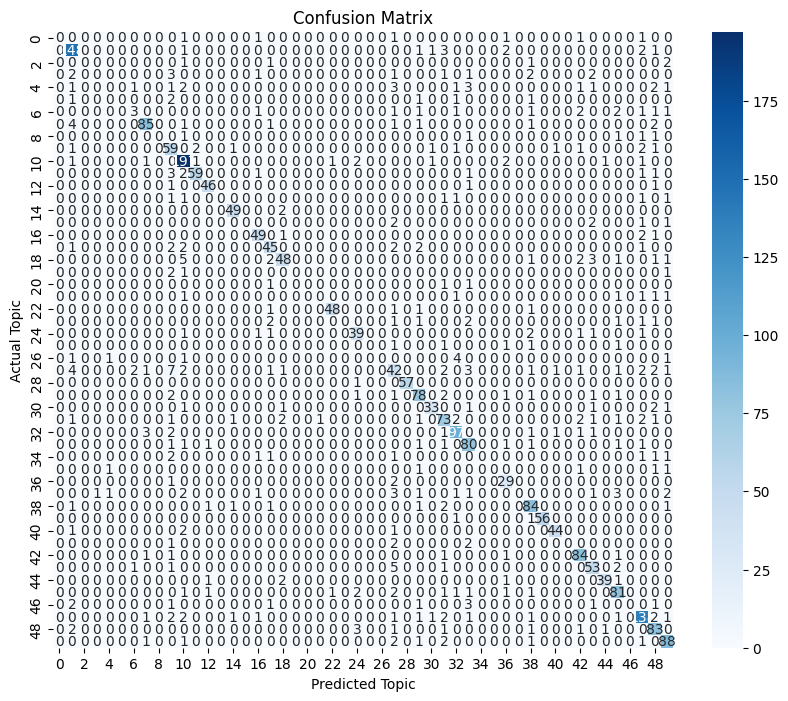

In [345]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Topic')
plt.ylabel('Actual Topic')
plt.title('Confusion Matrix')
plt.show()


## **Testing Model on single Input**

**Predict the topic based on unknown ticket description**

In [346]:
# Define a function which take single ticket infomoration and predict the topic label

def predict_ticket_topic(ticket_info):
  """
  Predicts the topic of a customer support ticket.

  Args:
    ticket_info: A dictionary containing the ticket information.

  Returns:
    The predicted topic of the ticket.
  """

  # Create a dataframe from the ticket information
  ticket_df = pd.DataFrame([ticket_info])

  # Extract the text content from the ticket
  text_content = ticket_df['Text_content']

  # Transform the text content using the TF-IDF vectorizer

  X_test_tfidf = tfidf_vectorizer.transform(ticket_df['Text_content'])

  # Predict the topic using the random forest classifier
  topic = clf.predict(X_test_tfidf)[0]

  # Predict the topic of the ticket
  topic = clf.predict(X_test_tfidf)[0]

  return topic


In [347]:
# Calling the function to predict the topic
inp = {'Text_content': "I'm having an issue with the {product_purchased}. Please assist. I don't think a product is in the same category as an {product_purchased}, as it wouldn't have been the issue in the case of the I've noticed that the issue occurs consistently when I use a specific feature or application on my {product_purchased}."}
predict_ticket_topic(inp)

42